In [1]:
from collections import Counter
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import torch
import torchaudio

### Dataset

In [13]:
spd = pd.read_csv('data/Sleep_FullDataset_withDuplicates.csv')
spd = spd.drop_duplicates(subset='TrackID', keep='first')
spd = spd.drop_duplicates(subset='TrackID', keep='first')

In [14]:
spd.shape

(130308, 28)

In [18]:
import requests

# URL from your dataframe
url = spd.loc[2, 'SampleURL']

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the content of the response
    audio_content = response.content
    
    # Write the content to a file
    with open('output_audio.wav', 'wb') as audio_file:
        audio_file.write(audio_content)
    print("Audio file downloaded successfully.")
else:
    print("Failed to retrieve the audio. Status code:", response.status_code)


Audio file downloaded successfully.


In [19]:
Counter(spd['TrackName'])

Counter({'Sleeping Music': 654,
         'Sleep Music': 595,
         'Deep Sleep': 592,
         'Music For Sleep': 481,
         'Sleep Aid': 345,
         'Relaxing Music': 303,
         'Ambient Music': 286,
         'Dynamite': 260,
         'Music For Sleeping': 259,
         'Binaural Beats': 248,
         'Deep Sleep Aid': 236,
         'Calm Music': 219,
         'Calm Sleeping Music': 213,
         'Calm Music For Sleep': 211,
         'Binaural Beats Sleep Aid': 195,
         'Deep Sleep Music': 188,
         'Home': 174,
         'Ambient Sleep Music': 168,
         'Soothing Music For Sleep': 167,
         'Soothing Music': 156,
         'Calm Sleep Music': 151,
         'Sleep': 146,
         'Alpha Waves': 145,
         'Relaxing Sleeping Music': 138,
         'Lullaby': 136,
         'Binaural Beats and Brainwave Entrainment': 134,
         'Soothing Sleep Music': 129,
         'Soothing Sleeping Music': 127,
         'Sleeping Music For Sleep': 123,
         'Baby Lull

### Torch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transform the data to torch.FloatTensor and normalize it
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Downloaded CIFAR10 dataset.")


100%|██████████| 170498071/170498071 [00:14<00:00, 11960509.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Downloaded CIFAR10 dataset.


In [5]:
import os
import torch
import torchaudio

# Define the path to save the data
data_folder = './data/speechcommands'
os.makedirs(data_folder, exist_ok=True)

# Download and load the training data
trainset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='training')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Download and load the validation data
valset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='validation')

valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)

# Download and load the test data
testset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='testing')

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

print("Downloaded SPEECHCOMMANDS dataset.")


100%|██████████| 2.26G/2.26G [01:22<00:00, 29.5MB/s] 


Downloaded SPEECHCOMMANDS dataset.


### Visualizing (lol?) Dataset

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.0023e-03, 4.8506e-08, 1.6935e-09,  ..., 1.3588e-09,
          2.0616e-06, 1.5228e-04],
         [2.4747e-03, 4.4818e-09, 4.3345e-08,  ..., 6.4700e-11,
          9.6698e-07, 1.5507e-04],
         [2.5268e-03, 2.3036e-10, 9.9184e-08,  ..., 5.3330e-11,
          7.9528e-07, 1.0238e-04]]]), 44100)


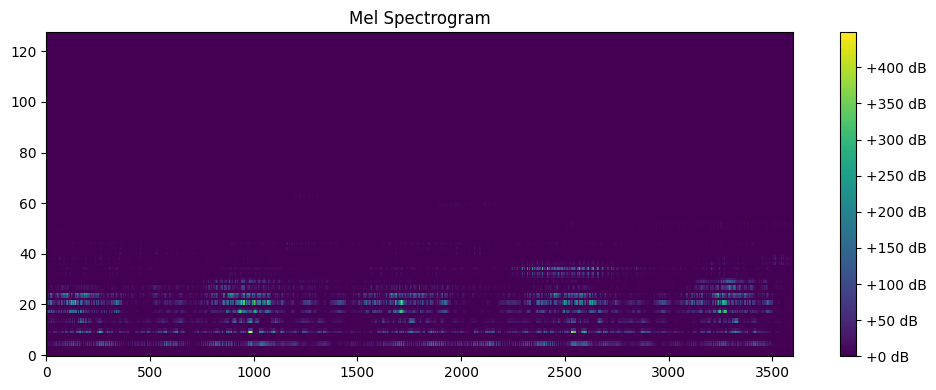

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the tensor
mel_spectrogram = torch.load('cache/data/spotify_sleep_dataset/mel-spectrogram/0_tensor.pt')
print(mel_spectrogram)
# Step 2: Convert the tensor to a NumPy array (if it's not already) and select one channel (e.g., the first channel)
mel_spectrogram = mel_spectrogram[0][0].numpy()  # This selects the first channel

# Step 3: Plot the Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram, aspect='auto', origin='lower', interpolation='none')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### Convert pt to wav

In [3]:
def convert_tensor_to_wav(tensor_file_path, wav_file_path):
    # Load the tensor and sample rate
    # print(torch.load(tensor_file_path))
    sample_rate = 22048
    waveform = torch.load(tensor_file_path)
    print(sample_rate)

    # Save the waveform as a .wav file
    torchaudio.save(wav_file_path, waveform, sample_rate)

In [5]:
tensor_file_path = 'data/test_generated/sample_62.pt'  # Update this path
wav_file_path = tensor_file_path.replace('.pt', '.wav')

convert_tensor_to_wav(tensor_file_path, wav_file_path)

22048


In [6]:
for i in range(0, 9):
    tensor_file_path = f'data/test_from_devgpu/sample_{i}.pt'
    wav_file_path = tensor_file_path.replace('.pt', '.wav')

    convert_tensor_to_wav(tensor_file_path, wav_file_path)

22048
22048
22048
22048
22048
22048
22048
22048
22048


In [6]:
import torch

# Load the file
pt_file, sample_rate = torch.load("cache/data/spotify_sleep_dataset/waveform/87_tensor.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'cache/data/spotify_sleep_dataset/waveform/87_tensor.pt'

In [35]:
pt_file.shape

torch.Size([1, 1323001])

In [17]:
print(len(pt_file))
print(len(pt_file[0]))

2
1


In [24]:
print(pt_file[0][0][0].shape)

torch.Size([3601])


In [31]:
pt_file[0][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

### Creating reference and test sets


In [2]:
import torch
import numpy as np
import os

# Function to generate a sine wave
def generate_sine_wave(freq, sample_rate, duration):
    t = torch.linspace(0, duration, int(sample_rate * duration))
    waveform = torch.sin(2 * np.pi * freq * t)
    return waveform

# Directories for saving the waveforms
reference_dir = 'data/test_reference'
generated_dir = 'data/test_generated'

# Create directories if they don't exist
os.makedirs(reference_dir, exist_ok=True)
os.makedirs(generated_dir, exist_ok=True)

# Parameters for the sine wave
sample_rate = 16000  # Sample rate in Hz
duration = 1  # Duration in seconds

# Generate and save 10 sine wave samples
for i in range(10):
    freq = 440 + i * 10  # Slightly different frequency for each sample
    
    # Generate sine wave
    waveform = generate_sine_wave(freq, sample_rate, duration)
    
    # Save to reference directory
    torch.save(waveform, os.path.join(reference_dir, f'sample_{i}.pt'))
    
    # Generate another sine wave (could modify parameters if needed)
    waveform_generated = generate_sine_wave(freq, sample_rate, duration)
    
    # Save to generated directory
    torch.save(waveform_generated, os.path.join(generated_dir, f'sample_{i}.pt'))

print("Waveform generation and saving completed.")


Waveform generation and saving completed.


### Testing Mel-Spectrograms

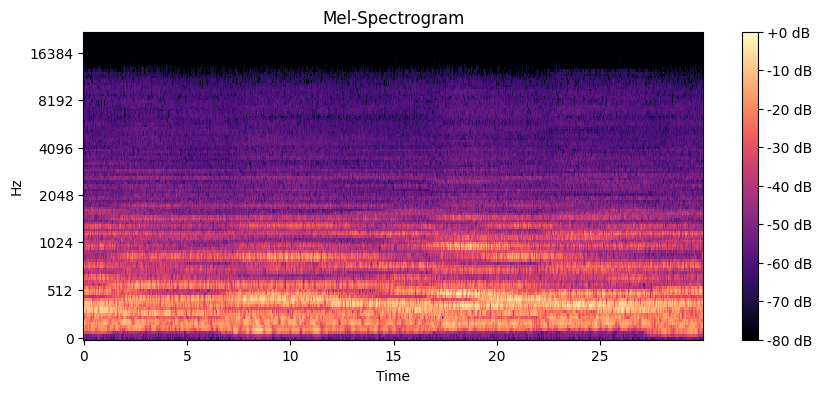

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_melspectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128, fmin=0, fmax=None):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Compute mel-scaled spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

    return mel_spectrogram

def plot_melspectrogram(mel_spectrogram, sr=22050, hop_length=512):
    # Convert power spectrogram to dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.show()

# Example usage
audio_path = 'output_audio.wav'
mel_spectrogram = audio_to_melspectrogram(audio_path, sr=44100)
plot_melspectrogram(mel_spectrogram, sr=44100)


In [7]:
mel_spectrogram.shape

(128, 1292)

### Testing MusicLang

In [2]:
from musiclang.library import *

# Write a C major chord (First degree of C major scale)
score = (I % I.M)(piano=[s0, s2, s4])

# Store it to midi
score.to_midi('c_major.mid')

/home/timoh/.local/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,EVENT_TYPE,OFFSET,PITCH,VELOCITY,DURATION,DELTA,TRACK,TEMPO,PEDAL
0,NOTE_ON,0,60,66,1,0,0,None,None
1,NOTE_ON,0,64,66,1,0,0,None,None
2,NOTE_ON,0,67,66,1,0,0,None,None
0,NOTE_OFF,1,60,66,1,1,0,None,None
1,NOTE_OFF,1,64,66,1,0,0,None,None
2,NOTE_OFF,1,67,66,1,0,0,None,None


In [3]:
from musiclang.library import *

# Create a cool melody (the beginning of happy birthday, independant of any harmonic context)
melody = s4.ed + s4.s + s5 + s4 + s0.o(1) + s6.h

# Create a simple accompaniment with a cello and a oboe
acc_melody = r + s0.o(-1).q * 3 + s0.o(-1).h
accomp = {'cello__0': acc_melody, 'oboe__0': acc_melody.o(1)}

# Play it in F-major
score = (I % IV.M)(violin__0=melody, **accomp)

# Repeat the score a second time in F-minor and forte
score += (score % I.m).f

# Just to create an anachrusis at the first bar
score = (I % I.M)(violin__0=r.h) + score

# Transform a bit the accompaniment by applying counterpoint rules automatically
score = score.get_counterpoint(fixed_parts=['violin__0'])

# Save it to musicxml
score.to_musicxml('happy_birthday.musicxml', signature=(3, 4), title='Happy birthday !')

### For Presentation


In [2]:
import torch
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np
from diffusers import DDPMScheduler

/home/timoh/anaconda3/envs/GEN_MUSIC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Assuming 'image.png' is your starting image
img = Image.open('image.png')
img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255

scheduler = DDPMScheduler(beta_start=0.02, beta_end=3)
model = None 

selected_timesteps = np.arange(0, 1000, 100) 

for timestep in tqdm(selected_timesteps):
    noise = torch.randn_like(img_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_img = img_tensor + noise

    generated_img = noisy_img.clamp(0, 1)

    generated_img_pil = Image.fromarray((generated_img.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    generated_img_pil.save(f'sample_images/generated_image_{timestep}.png')


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


In [36]:
from PIL import Image
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from diffusers import DDPMScheduler

# Assuming 'image.png' is your starting image
img = Image.open('sample_images/noised_mel_spectrogram.png').convert('L')  # Convert to grayscale ('L' mode)
img_tensor = torch.from_numpy(np.array(img)).unsqueeze(0).unsqueeze(0).float() / 255  # Shape (1, 1, H, W)

scheduler = DDPMScheduler(beta_start=0.0001, beta_end=0.2)
model = None  # Assuming you have a model to generate or denoise images

selected_timesteps = np.arange(0, 1000, 100)

for timestep in tqdm(selected_timesteps):
    noise = torch.randn_like(img_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_img = img_tensor + noise

    generated_img = noisy_img.clamp(0, 1)

    # Since it's a 1-channel image, remove the channel dimension when saving it
    generated_img_pil = Image.fromarray((generated_img.squeeze().numpy() * 255).astype(np.uint8))
    generated_img_pil.save(f'sample_images/noised_mel_spectrogram_0{timestep}.png')


100%|██████████| 10/10 [00:00<00:00, 404.80it/s]


In [50]:
from pydub import AudioSegment

# Load the MP3 file
audio = AudioSegment.from_mp3("sample_images/daft_punk.mp3")

# Define start and end times in milliseconds
start_time = 1 * 60 * 1000 + 33 * 1000 + 1700  # 1 minute, 33.5 seconds
end_time = start_time + 3000  # 3 seconds later

# Extract the clip
clip = audio[start_time:end_time]

# Export the clip to a new file
clip.export("sample_images/daft_punk_clip.mp3", format="mp3")


<_io.BufferedRandom name='sample_images/daft_punk_clip.mp3'>

In [55]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io.wavfile import write
from torchvision.transforms.functional import to_pil_image

# Your waveform and sampling rate loading logic here
waveform, sr = librosa.load("sample_images/daft_punk_clip.mp3", sr=None)

# Ensure the waveform and Mel spectrogram are in tensor format
waveform_tensor = torch.FloatTensor(waveform).unsqueeze(0).unsqueeze(0)  # Add channel and batch dimensions

scheduler = DDPMScheduler(beta_start=0.1, beta_end=0.9)
selected_timesteps = np.arange(0, 1000, 100)

for timestep in selected_timesteps:
    # Apply noise to waveform
    noise_waveform = torch.randn_like(waveform_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_waveform = waveform_tensor + noise_waveform
    write(f'sample_images/noised_waveform_{timestep}.wav', sr, noisy_waveform.squeeze().numpy())

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
import os

# List all .wav files in the sample_images directory
wav_files = glob.glob('sample_images/*900.wav')

for wav_file in tqdm(wav_files):
    # Extract file name without the directory path and extension
    file_name = os.path.basename(wav_file).split('.')[0]

    # Load your WAV file
    samplerate, data = wavfile.read(wav_file)

    # Handle stereo audio by taking one channel
    if data.ndim > 1:
        data = data[:, 0]

    # Normalize data
    data = data / np.max(np.abs(data))

    # Plotting the waveform
    plt.figure(figsize=(20, 4), frameon=False)
    plt.plot(data, color='black')
    plt.axis('off')  # This removes the axis and labels
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Save the figure with a file name based on the original wav file
    output_file_name = f'sample_images/{file_name}_waveform.png'
    plt.savefig(output_file_name, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to free memory for the next iteration


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
